The code comes from: https://www.kaggle.com/code/robikscube/tutorial-time-series-forecasting-with-xgboost, https://www.kaggle.com/code/robikscube/time-series-forecasting-with-machine-learning-yt and https://www.kaggle.com/code/robikscube/pt2-time-series-forecasting-with-xgboost/notebook

In [283]:
#imports for the notebook
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
plt.style.use('fivethirtyeight')

In [264]:
#dataframes
dfD = pd.read_csv("https://raw.githubusercontent.com/kaebry/DSF/main/Data/clean_data/daily_data.csv") #Daily data
dfW = pd.read_csv("https://raw.githubusercontent.com/kaebry/DSF/main/Data/clean_data/weekly_data.csv") #Weekly data
dfM = pd.read_csv("https://raw.githubusercontent.com/kaebry/DSF/main/Data/clean_data/monthly_data.csv") #Monthly data

In [265]:
df_list = [dfD, dfW, dfM] #A lsit with all the dataframes

In [266]:
    # Define a function to set datetime as index
def datetime_as_index(df):
        if 'Unnamed: 0' in df.columns:
            df.rename(columns={"Unnamed: 0": "datetime"}, inplace = True)
        df["datetime"] = pd.to_datetime(df["datetime"])
        df = df.set_index("datetime")
        #drop Nan values
        df.dropna(inplace=True)
        return df

In [267]:
df_list = [datetime_as_index(df) for df in df_list] #Set the datetime as index for the dataframes

In [268]:
dfD, dfW, dfM = df_list

# Adding lags as a feature / USEFUL?

In [269]:
#We can use past values of our target variable as a feature

#def add_lags(df):
 #   target_map = df['water_level'].to_dict()
  #  df['lag1'] = (df.index - pd.Timedelta('1 days')).map(target_map) #we use value from the day before
   # df['lag2'] = (df.index - pd.Timedelta('5 days')).map(target_map)
   # df['lag3'] = (df.index - pd.Timedelta('10 days')).map(target_map)
   # return df

In [270]:
#df_train_val = add_lags(df_train_val)

In [271]:
#Adding lags to list of features
#Features.extend(('lag1','lag2','lag3'))

# Split in train/test datasets

In [272]:
#Split train/test
split_date_test = '2019-01-01'
df_list_train_val = [df.loc[df.index <= split_date_test].copy() for df in df_list]
df_list_test = [df.loc[df.index > split_date_test].copy() for df in df_list]

In [273]:
dfD_train_val, dfW_train_val, dfM_train_val = df_list_train_val 
dfD_test, dfW_test, dfM_test = df_list_test

In [274]:
#Split train/validation
split_date_val = '2018-01-01'
df_list_train = [df.loc[df.index <= split_date_val].copy() for df in df_list_train_val]
df_list_val = [df.loc[df.index > split_date_val].copy() for df in df_list_train_val]

In [275]:
dfD_train, dfW_train, dfM_train = df_list_train
dfD_val, dfW_val, dfM_val = df_list_val

# Evaluation metrics

In [276]:
def mean_errors_print(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    MAE = mae(actual, pred)
    MSE = np.square(np.subtract(actual,pred)).mean()
    MAPE = np.mean(np.abs((actual - pred) / actual)) * 100
    R2_score = r2_score(actual, pred)
    return print("MAE: {} \nMSE: {} \nMAPE: {} \nR2: {}".format(MAE, MSE, MAPE, R2_score))

# Create XGBoost model

In [277]:
#Features used for the prediction
Features = ['suction_tension (20cm)', 'suction_tension (40cm)',
       'suction_tension (70cm)', 'water_temperature',
       'barometric_pressure_qfe', 'dew_point',
       'inflow_linth (m3/s)', 'outflow_limmat (m3/s)', 'precipitation (mm)',
       'change_rate', 'Evapotranspiration (mm)']
#Target variable
Target = 'water_level'

In [278]:
#Train dataset is split in features and target datasets
X_list_train = [df[Features] for df in df_list_train]
y_list_train = [df[Target] for df in df_list_train]

#Validation dataset is split in features and target datasets
X_list_val = [df[Features] for df in df_list_val]
y_list_val = [df[Target] for df in df_list_val]

**Grid search to find best hyperparameters / TO BE ADDED**

In [286]:
'''
model = xgb.XGBClassifier()
    
n_estimators = range(50, 400, 50)
    
param_grid = dict(n_estimators=n_estimators)
    
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
    
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_list_train[0], y_list_train[0])
'''

'\nmodel = xgb.XGBClassifier()\n    \nn_estimators = range(50, 400, 50)\n    \nparam_grid = dict(n_estimators=n_estimators)\n    \nkfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)\n    \ngrid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)\ngrid_result = grid_search.fit(X_list_train[0], y_list_train[0])\n'

In [281]:
reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, early_stopping_rounds=50, learning_rate=0.01, max_depth=3)
k = 0
reg.fit(X_list_train[k], y_list_train[k],
        eval_set=[(X_list_train[k], y_list_train[k]), (X_list_val[k], y_list_val[k])],
        verbose=100)

[0]	validation_0-rmse:401.37740	validation_1-rmse:401.34271
[100]	validation_0-rmse:146.98483	validation_1-rmse:146.95012
[200]	validation_0-rmse:53.82611	validation_1-rmse:53.79137
[300]	validation_0-rmse:19.71151	validation_1-rmse:19.67667
[400]	validation_0-rmse:7.21947	validation_1-rmse:7.18437
[500]	validation_0-rmse:2.64599	validation_1-rmse:2.61247
[600]	validation_0-rmse:0.97180	validation_1-rmse:0.94554
[700]	validation_0-rmse:0.35971	validation_1-rmse:0.33805
[800]	validation_0-rmse:0.13883	validation_1-rmse:0.12696
[900]	validation_0-rmse:0.06459	validation_1-rmse:0.06481
[999]	validation_0-rmse:0.04471	validation_1-rmse:0.05482


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=3, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

# Feature Importance

In [257]:
fi = pd.DataFrame(data=reg.feature_importances_, index=reg.feature_names_in_, columns = ["importance"])

fi

,importance
suction_tension (20cm),0.042061
suction_tension (40cm),0.041127
suction_tension (70cm),0.043144
water_temperature,0.194910
barometric_pressure_qfe,0.030672
dew_point,0.041527
inflow_linth (m3/s),0.175739
outflow_limmat (m3/s),0.298730
precipitation (mm),0.013473
change_rate,0.040092


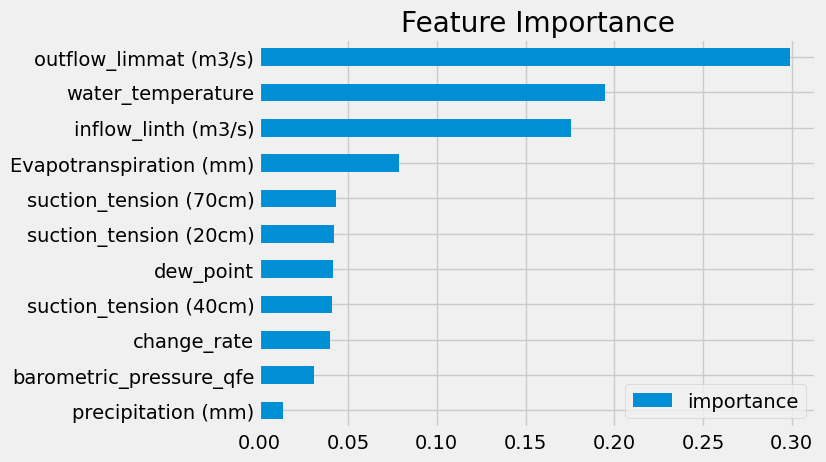

In [258]:
#Plot what has been the most used by the model
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Forecast on test data

In [233]:
for i in range(len(X_list_val)):
    X_list_val[i]['prediction'] = reg.predict(X_list_val[i])

In [234]:
def plot_pred(x, y, true_col, pred_col, title):

        fig, ax = plt.subplots(figsize=(12,5))
        ax.grid()
        ax.plot(y, label = true_col)
        ax.plot(x[pred_col], label = pred_col)
        ax.set_title(title)
        ax.legend()    

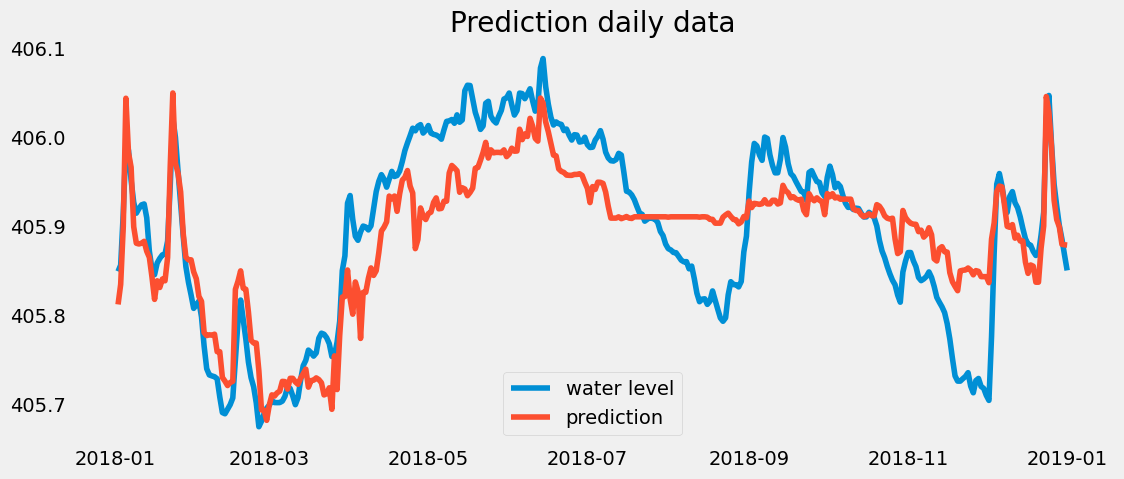

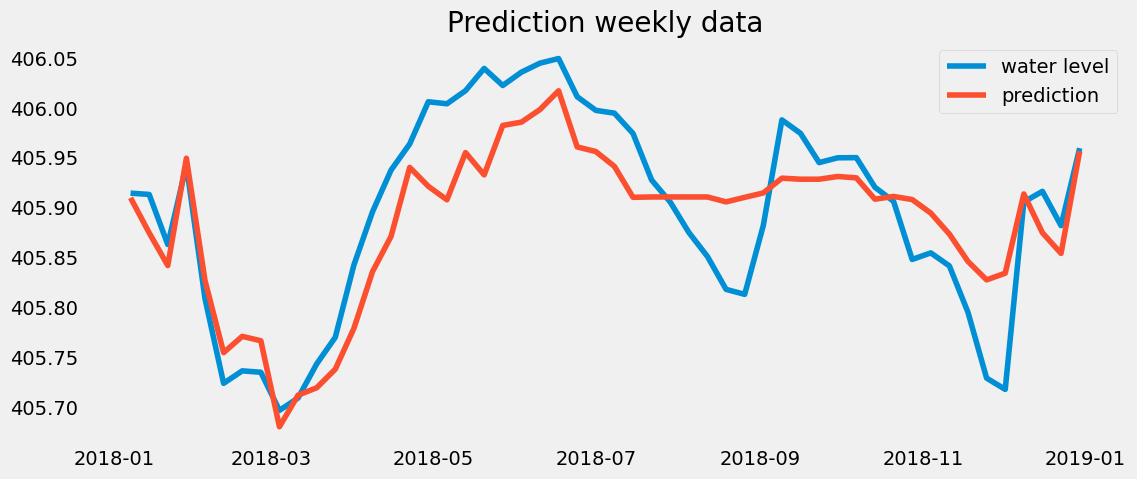

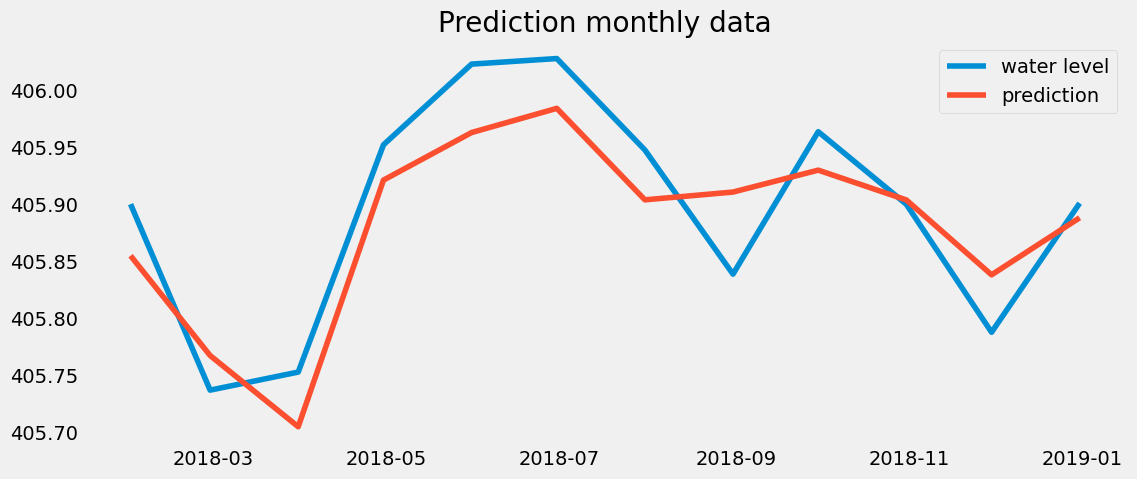

In [235]:
plot_pred(X_list_val[0], y_list_val[0], 'water level', 'prediction', 'Prediction daily data')
plot_pred(X_list_val[1], y_list_val[1], 'water level', 'prediction', 'Prediction weekly data')
plot_pred(X_list_val[2], y_list_val[2], 'water level', 'prediction', 'Prediction monthly data')

# Evaluation metrics

In [236]:
DWM = ['Daily data', 'Weekly data', 'Monthly data']

for i in range(len(X_list_val)):
    print(f'{DWM[i]}:')
    mean_errors_print(X_list_val[i]['prediction'], y_list_val[i])

Daily data:
MAE: 0.04502052416285579 
MSE: 0.003005275184818736 
MAPE: 0.011091784214298073 
R2: 0.48101191169019475
Weekly data:
MAE: 0.04217859028314418 
MSE: 0.002594928479458428 
MAPE: 0.010391616688180269 
R2: 0.5448774021855844
Monthly data:
MAE: 0.03962363699609739 
MSE: 0.0018973411420297702 
MAPE: 0.009762358792169504 
R2: 0.6749544504048107


# Other approach to time series cross validation

In [332]:
from sklearn.model_selection import TimeSeriesSplit

tssD = TimeSeriesSplit(n_splits=5, test_size=300, gap=1)
tssW = TimeSeriesSplit(n_splits=5, test_size=42, gap=1)
tssM = TimeSeriesSplit(n_splits=5, test_size=10, gap=1)
#df = df.sort_index()

In [333]:
def graph_fold(df, tss):
    fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)
    fold = 0
    for train_idx, val_idx in tss.split(df):
        train = df.iloc[train_idx]
        test = df.iloc[val_idx]
        train['water_level'].plot(ax=axs[fold],
                              label='Training Set',
                              title=f'Data Train/Test Split Fold {fold}')
        test['water_level'].plot(ax=axs[fold],
                             label='Test Set')
        axs[fold].axvline(test.index.min(), color='black', ls='--')
        fold += 1
    plt.show()

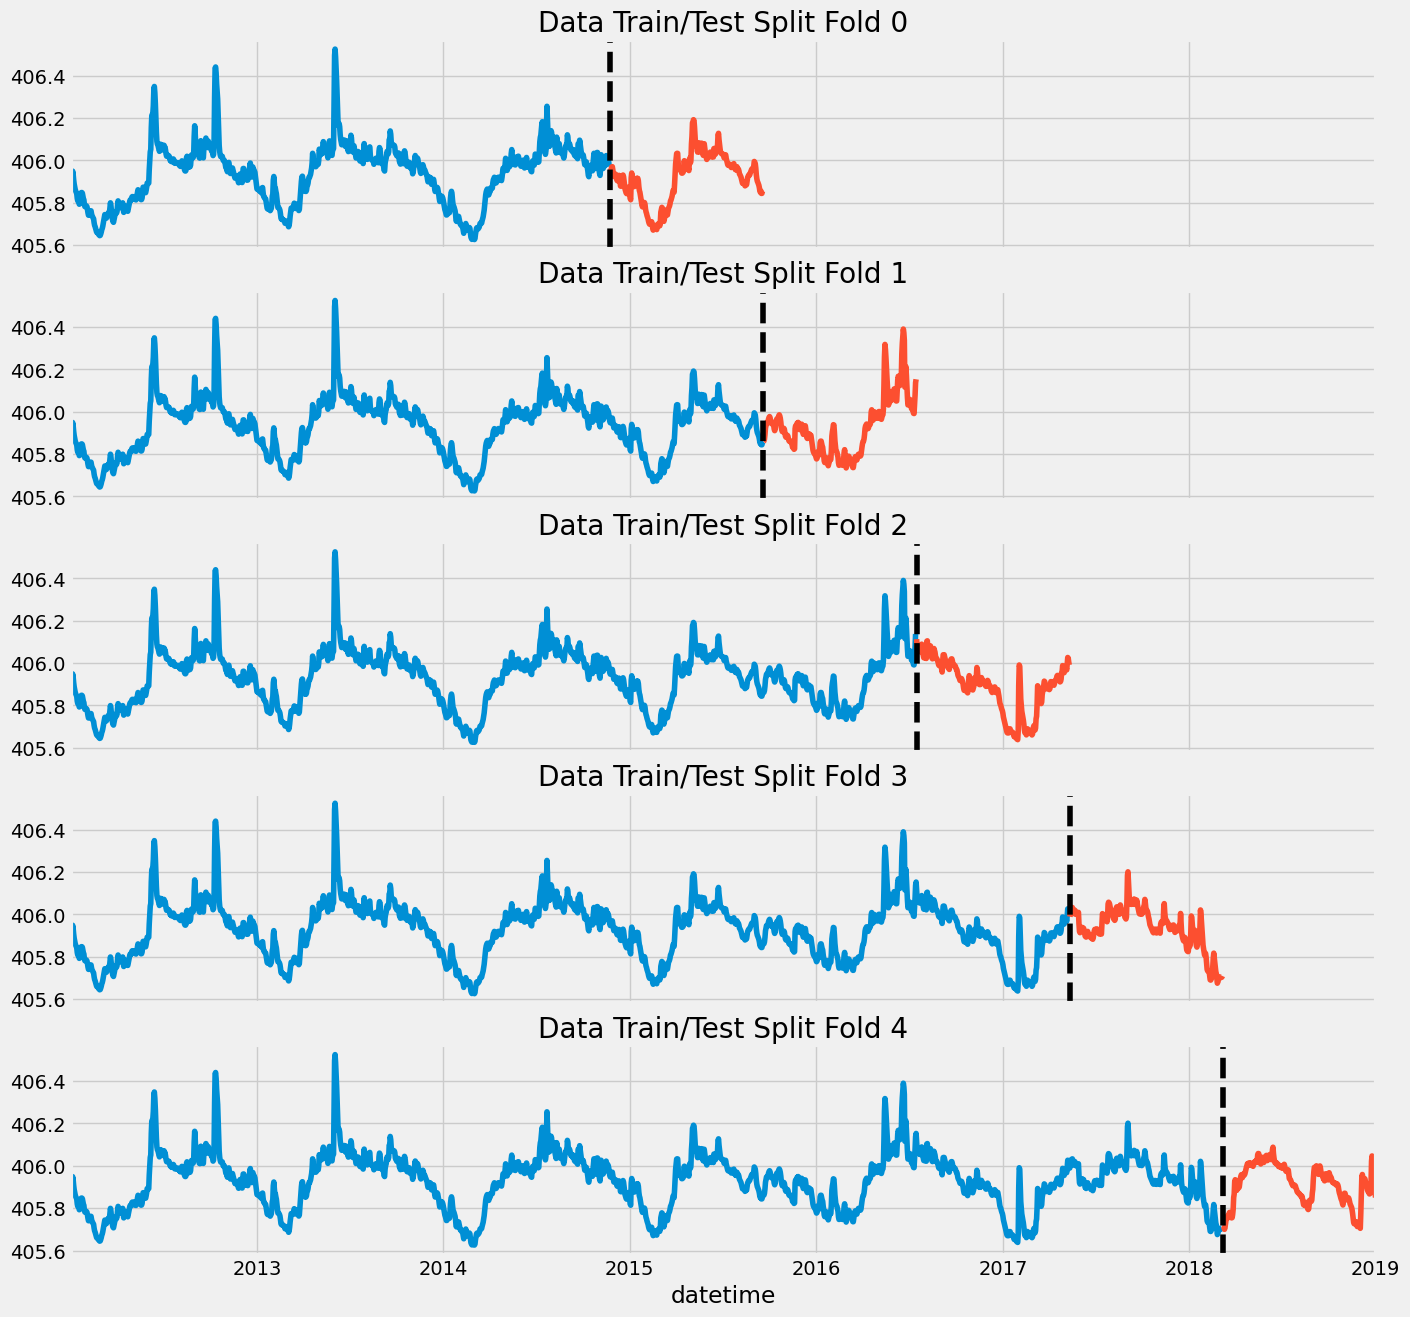

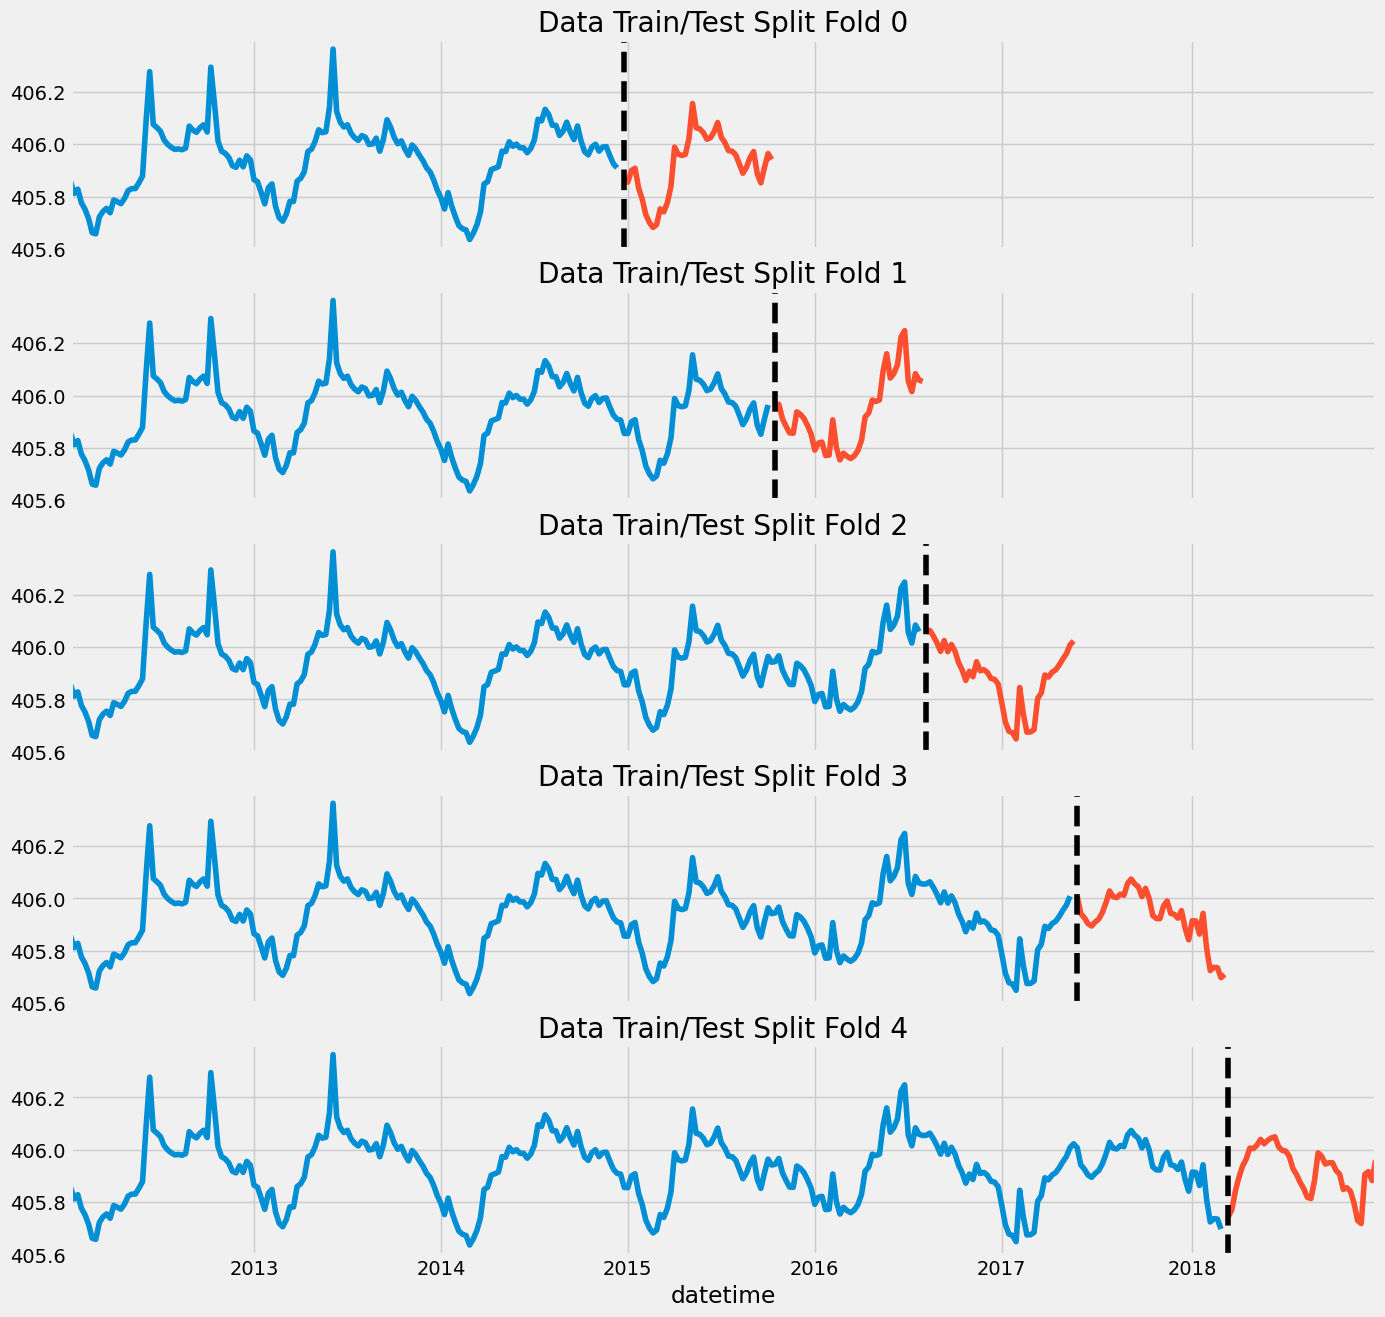

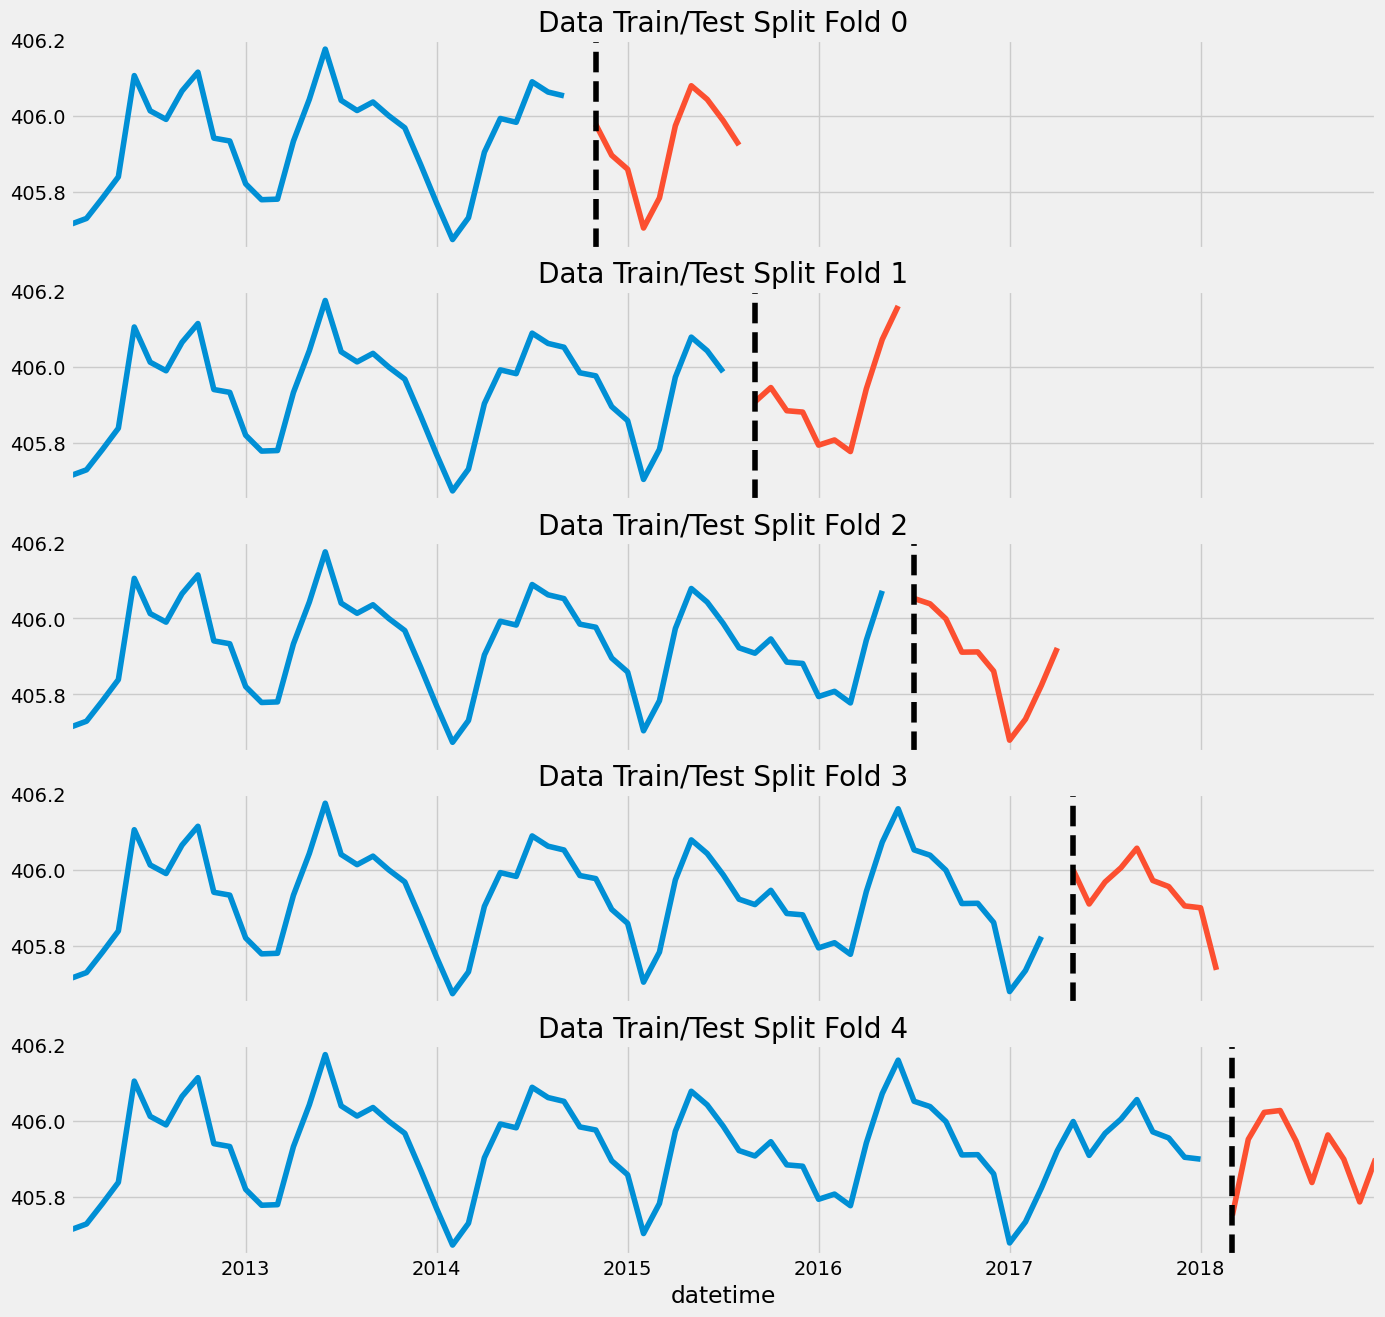

In [334]:
graph_fold(df_list_train_val[0], tssD)
graph_fold(df_list_train_val[1], tssW)
graph_fold(df_list_train_val[2], tssM)

# Training and testing with cross validation / TO BE ADDED

In [ ]:


tss = TimeSeriesSplit(n_splits=5, test_size=300, gap=1)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df_train_val):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    X_train = train[Features]
    y_train = train[Target]

    X_test = test[Features]
    y_test = test[Target]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[16:31:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:401.407	validation_1-rmse:401.387
[100]	validation_0-rmse:147.246	validation_1-rmse:147.226
[200]	validation_0-rmse:54.0137	validation_1-rmse:53.9939
[300]	validation_0-rmse:19.8139	validation_1-rmse:19.7941
[400]	validation_0-rmse:7.26926	validation_1-rmse:7.24924
[500]	validation_0-rmse:2.66947	validation_1-rmse:2.64906
[600]	validation_0-rmse:0.982957	validation_1-rmse:0.950683
[700]	validation_0-rmse:0.364096	validation_1-rmse:0.33084
[800]	validation_0-rmse:0.137606	validation_1-rmse:0.112445
[900]	validation_0-rmse:0.056171	validation_1-rmse:0.057335
[999]	validation_0-rmse:0.029052	validation_1-rmse:0.058495
[16:32:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:401.396	validation_1-rmse:401.334
[100]	validation_0-rmse:147.118	validation_1-

In [ ]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 0.0507
Fold scores:[0.058485228667999094, 0.04224764297430288, 0.05751094629260933, 0.04354027000218367, 0.051667998875197754]


# Walk forward / TO BE ADDED

# The prediction / TO BE ADDED

In [ ]:
df_test['pred'] = reg.predict(df_test[Features])


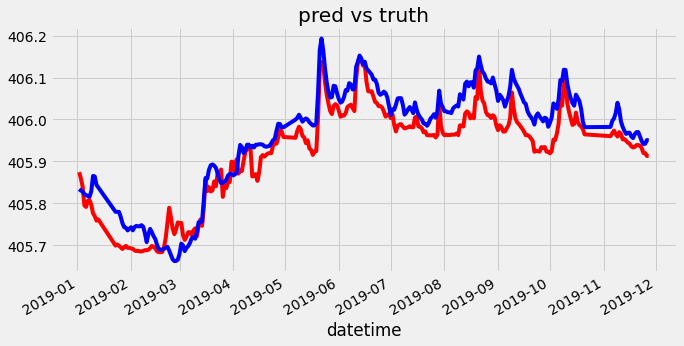

In [ ]:
df_test['pred'].plot(figsize=(10, 5),
                               color="red",
                               title='pred vs truth')
df_test['water_level'].plot(color="blue")
plt.show()